# DNS TXT records analysis
In this notebook we'll take a look into TXT records statistics. We'll use data generated by shell script located in `src/txt_analysis/monthly_statistics.sh`. To get the data in a usable form, we download it first from HDFS by issuing following command:
```
hdfs dfs -copyToLocal 201*results.txt ~
```
Then we just run `src/combine.sh` script.
We now have `201YMMDD_results.json` files that we can use for presentation.
We put them in `data/txt_analysis_results` directory.

In [46]:
import os
import json
import re
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import numpy as np
from itertools import cycle

file_location = (
    os.path.normcase(
        os.path.join(os.getcwd(), "../data/txt_analysis_results")
    )
)

data_points = []
for filename in os.listdir(file_location):
    with open(os.path.join(file_location, filename), "r") as file:
        data_points.append(eval(file.read()))
        
def convert_LD_to_DL(dictionaries):
    dl = {}
    for key, value in dictionaries[0].items():
        if type(value) is not dict:
            dl[key] = get_summary_for_from(key, dictionaries)
        else:
            dl[key] = convert_LD_to_DL([entry[key] for entry in dictionaries])
    return dl

def get_summary_for_from(key, list_of_dictionaries):
    summary = np.array([])
    for result in list_of_dictionaries:
        summary = np.append(summary, result[key])
    return summary

def sum_over_children(dictionary):
    summary = np.zeros(len(data_points))
    for key, value in dictionary.items():
        if type(value) is not dict:
            summary += value
        else:
            summary += sum_over_children(value)
    return summary

def sum_over_children_single(dictionary):
    summary = 0
    for key, value in dictionary.items():
        if type(value) is not dict:
            summary += value
        else:
            summary += sum_over_children_single(value)
    return summary
    
summary = convert_LD_to_DL(data_points)
labels = summary["day"]

class Line:
    def __init__(self, points, color, info):
        self.points = points
        self.color = color
        self.info = info

def make_a_time_graph(title, data, labels=labels):
    fig, ax = plt.subplots()
    prepare_basic_line_graph(title)
    for entry in data:
        plt.plot(labels, entry.points, entry.color, label=entry.info)
    ax.legend(loc='center right', shadow=True, bbox_to_anchor=(1.2, 0.5))
    plt.show()
    
def prepare_basic_line_graph(title):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 8
    plt.rcParams["figure.figsize"] = fig_size
    plt.xlabel('Month')
    plt.xticks(rotation=60)
    plt.ylabel('Number')
    plt.grid()
    plt.title(title)
    
def make_a_pie_chart(title, values, labels):
    plt.title(title)
    plt.pie(values, labels=labels)
    plt.show()

## TXT records in the whole dataset

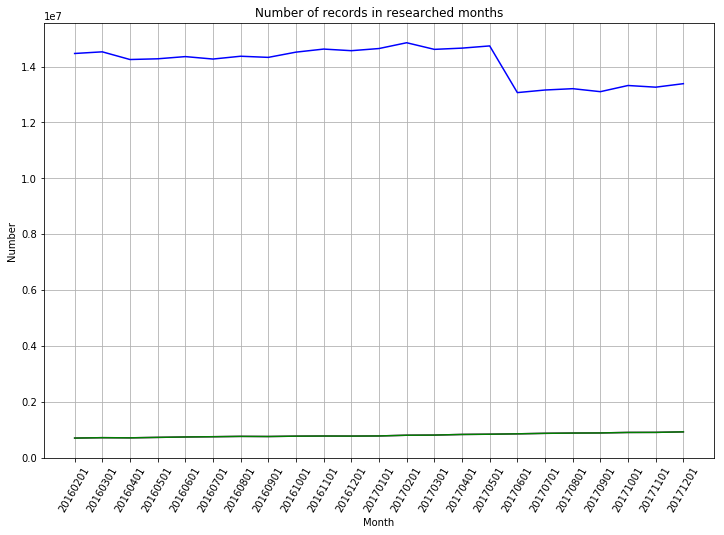

Highest percentage: 6.93%


In [2]:


prepare_basic_line_graph('Number of records in researched months')
plt.plot(labels, summary["total"], color='blue')
plt.plot(labels, summary["txt"], color='purple')
plt.plot(labels, summary["correct_txt"], color='green')

plt.show()

percentages = summary["txt"] / summary["total"]
print("Highest percentage: {:.2%}".format(percentages.max()))

As we can see, TXT records make up only a small percentage of all records.
Let's look at incorrect values.

Empty records red


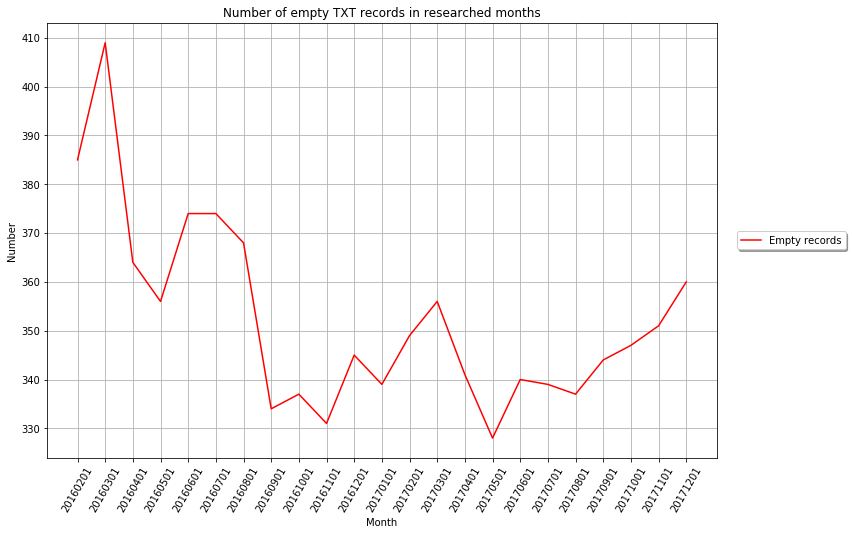

In [3]:
lines = [Line(summary["txt"] - summary["correct_txt"], 'red', "Empty records")]
make_a_time_graph('Number of empty TXT records in researched months', lines)

## Usages
Let's see now, what are the most common uses for TXT records.

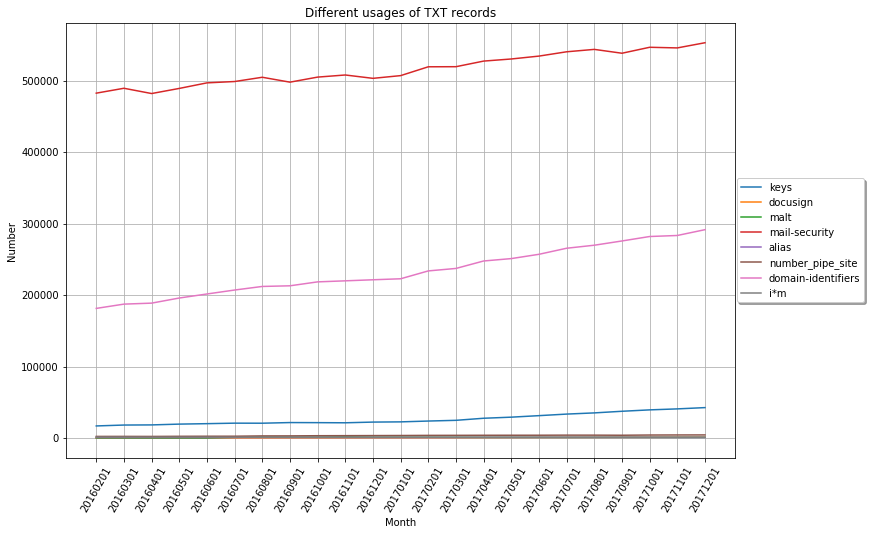

In [33]:
lines = []
itr = 0
for key, value in summary["specific"].items():
    if type(value) is dict:
        lines.append(Line(sum_over_children(value), 'C'+str(itr), key))
    else:
        lines.append(Line(value, 'C' + str(itr), key))
    itr += 1
make_a_time_graph('Different usages of TXT records', lines)

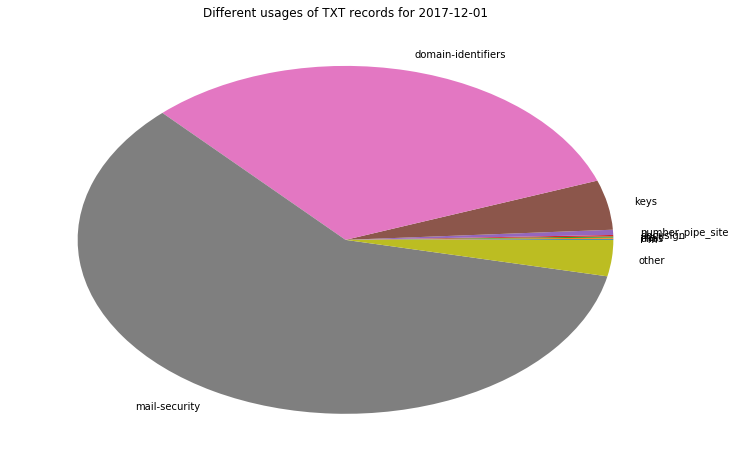

In [49]:
values = []
labels = []
for key, value in data_points[-1]["specific"].items():
    labels.append(key)
    if type(value) is dict:
        values.append(sum_over_children_single(value))
    else:
        values.append(value)
values, labels = (list(t) for t in zip(*sorted(zip(values, labels))))

labels.append("other")
values.append(data_points[-1]["correct_txt"] - sum(values))
make_a_pie_chart('Different usages of TXT records for 2017-12-01', values, labels)

As we can see, mail security, domain identifiers and just keys make up most of the collected TXT records. Let's see the components of mail security:

In [41]:
print (data_points[-1]["specific"]["mail-security"])

{'dmarc': 1692, 'dkim': 2141, 'spf': 549166}


Presenting a pie chart makes no sense here, obviously.

## Domain identifiers
The big part of TXT records is domain identifiers group. The proportions in this group look as follows:

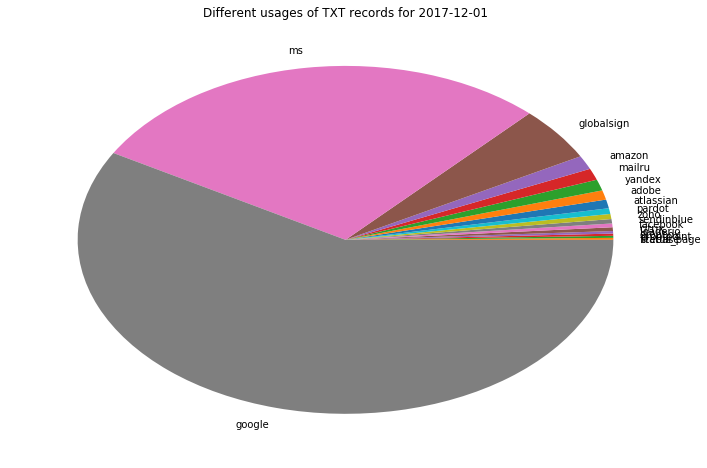

In [48]:
values = []
labels = []
itr = 0
for key, value in data_points[-1]["specific"]["domain-identifiers"].items():
    labels.append(key)
    values.append(value)
    itr += 1
values, labels = (list(t) for t in zip(*sorted(zip(values, labels))))

make_a_pie_chart('Different usages of TXT records for 2017-12-01', values, labels)

## Original question - are there any sensitive data?
The question proved to more difficult, than it seems.

There are no papers on this topic (automatic sensitive data recognition), so we came up with something as simple as possible - just search for string such as "password", "pswd" etc.
And, surprisingly, we found a few things, such as:
<img src="assets/private_key.jpeg"/>
Or, partially sensitive:
<img src="assets/login.png"/>

## Other records
The records we failed to assign were mostly configuration errors such as:
<img src="assets/wrong_conf.png"/>
<img src="assets/wrong_conf1.png"/>
<img src="assets/wrong_conf2.png"/>
<img src="assets/funny.png"/>

There were also other domain identification records, some of them not popular enough to make a difference:
<img src="assets/other.png"/>